# AutoRegressive flows and RealNVP

> In this post, we are going to take a look at Autoregressive flows and RealNVP. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/trainable_dist.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview - AutoRegressive Flows

There are several approaches to implement normalizing flow. Here, we'll cover autoregressive flow implementation.

### Masked Autoregressive Flows 

If the flow has autogressive property, then its log det jacobian calculation may be easy since log det jacobian matrix is lower triangular. Tensorflow bijector has [AutogressiveNetwork](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork) class for this usage. Actually, it is not a bijector, though. Example case is an implementation of **MADE** architecture, which stands for *Masked Autoencoder for Distribution Estimation*. If you have interests about this, take a look at this [paper](http://proceedings.mlr.press/v37/germain15.pdf), published in ICML 2015. 

In [3]:
# z ~ N(0, I)
# x[i] = z[i] * scale(x[0:i-1]) + loc(x[0:i-1]), i=0,...,D-1

# event_shape : input_shape
# hidden_units : the number of nodes in each hidden layers. In this case, it has two hidden layers with 16 nodes.
# params: the extra dimension for output shape

made = tfb.AutoregressiveNetwork(
    params=2, event_shape=[3], hidden_units=[16, 16], activation='sigmoid'
)

In [4]:
made(tf.random.normal([2, 3]))

<tf.Tensor: shape=(2, 3, 2), dtype=float32, numpy=
array([[[ 0.        ,  0.        ],
        [ 0.38081244,  0.12547036],
        [ 0.00570101, -0.18258214]],

       [[ 0.        ,  0.        ],
        [ 0.36578014,  0.12359573],
        [-0.02715817, -0.09323801]]], dtype=float32)>

In this case, input has 2x3 shape, and output has 2 batched 2x3 array, that is (2, 3, 2). Note that the right most element (2) is from `params` argument. Using this, we can define masked autoregressive flow bijector.

In [6]:
maf_bijector = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

Then we can write the pseudocode for forward transformation like this,

```python

def forward(z):
    x = tf.zeros_like(z)
    for _ in range(D):
        shift, log_scale = shift_and_log_scale_fn(x)
        x = z * tf.math.exp(log_scale) + shift
    return x
```

When the random variable `z` is given, shift and scale factor is calculated for each feature. Afterthat, all features in x will be updated correctly.

```python
def inverse(x):
    shift, log_scale = shift_and_log_scale_fn(x)
    return (x - shift) / tf.math.exp(log_scale)
```

The inverse operation is much simpler.

In [10]:
normal = tfd.Normal(loc=0, scale=1)
maf = tfd.TransformedDistribution(tfd.Sample(normal, sample_shape=[3]), maf_bijector)
maf

<tfp.distributions.TransformedDistribution 'masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[3] dtype=float32>

Or we can implement it like this,

In [11]:
maf_bijector = tfb.MaskedAutoregressiveFlow(
    lambda y: (made(y)[..., 0], None),
    is_constant_jacobian=True
)

maf = tfd.TransformedDistribution(tfd.Sample(normal, sample_shape=[3]), maf_bijector)
maf

<tfp.distributions.TransformedDistribution 'masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[3] dtype=float32>

In this case, masked autoregressive bijector has no scale. It means that the jacobian of this transformation will constant and that is identity. So we defined `is_constant_jacobian` argument to `True` for the efficiency. For the reference, if you want to track whole variables of MADE network in tensorflow. we need to reference the model variable. 

In [12]:
maf_bijector._made = made

### Inverse Autoregressive Flow (IAF)

In [13]:
iaf_bijector = tfb.Invert(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))

iaf = tfd.TransformedDistribution(tfd.Sample(normal, sample_shape=[3]), iaf_bijector)
iaf

<tfp.distributions.TransformedDistribution 'invert_masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[3] dtype=float32>

## Overview - RealNVP

In [14]:
# z ~ N(0, I)
# x[0: d] = z[0: d]
# x[d: D] = z[d: D] * scale(z[0: d]) + loc(z[0: d])

shift_and_log_scale_fn = tfb.real_nvp_default_template(
    hidden_layers=[32, 32], activation='relu'
)

In [15]:
shift_and_log_scale_fn(tf.random.normal([2]), 1)

/home/chanseok/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/chanseok/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2183: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.61401653], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.2952342], dtype=float32)>)

We can use only shifted flow by using `shift_only` keyword. In this case, scale parameter is fixed to 1.

In [16]:
shift_and_log_scale_fn = tfb.real_nvp_default_template(hidden_layers=[32, 32], activation='relu', shift_only=True)
shift_and_log_scale_fn(tf.random.normal([2]), 1)

/home/chanseok/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/chanseok/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2183: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.21404491], dtype=float32)>,
 None)

This kind of model is called *NICE*, which stands for Nonlinear Independent Components Estimation. This shift-only version has the property of jacobian matrix to identity. In this case, bijective transformation is volume preserving. Actually, RealNVP is acronym for real-valued Non-Volume Preserving.

In [19]:
# num_masked: defines the first partition of the vectors x and z

realnvp_bijector = tfb.RealNVP(
    num_masked=2, shift_and_log_scale_fn=shift_and_log_scale_fn
)

```python
def forward(z):
    x = tf.zeros_like(z)
    x[0: d] = z[0: d]
    shift, log_scale = shift_and_log_scale_fn(z[0: d])
    x[d: D] = z[d: D] * tf.math.exp(log_scale) + shift
    return x

def inverse(x):
    z = tf.zeros_like(x)
    z[0: d] = x[0: d]
    shift, log_scale = shift_and_log_scale_fn(x[0: d])
    z[d: D] = (x[d: D] - shift) * tf.math.exp(-log_scale)
    return z
```

In [20]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0., 0.])
realnvp = tfd.TransformedDistribution(distribution=mvn, bijector=realnvp_bijector)

We can define the fraction of masked data by using `fraction_masked` keyword, instead of using `num_masked`.

In [21]:
realnvp_bijector = tfb.RealNVP(
    fraction_masked=0.5, shift_and_log_scale_fn=shift_and_log_scale_fn
)

### Chained RealNVP bijector

In [22]:
permute = tfb.Permute(permutation=[1, 2, 0])

realnvp1 = tfb.RealNVP(fraction_masked=0.5, shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[32, 32]))
realnvp2 = tfb.RealNVP(fraction_masked=0.5, shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[32, 32]))
realnvp3 = tfb.RealNVP(fraction_masked=0.5, shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[32, 32]))

chained_bijector = tfb.Chain([realnvp3, permute, realnvp2, permute, realnvp1])

realnvp = tfd.TransformedDistribution(distribution=mvn, bijector=chained_bijector)

## Tutorial

### Load dataset

In [23]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)

xlim, ylim = [-2, 2], [-2, 2]

### Plot with labels

In [25]:
y_label = y.astype(np.bool_)
X_train, y_train = X_data[..., 0], X_data[..., 1]

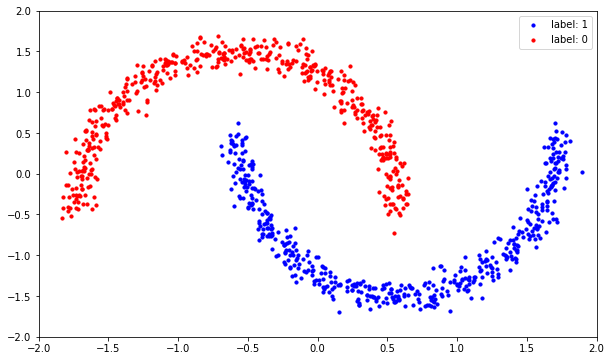

In [27]:
plt.scatter(X_train[y_label], y_train[y_label], s=10, color='blue')
plt.scatter(X_train[~y_label], y_train[~y_label], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [28]:
# Define base distribution

base_dist = tfd.Normal(loc=0, scale=1)

In [30]:
# Define the trainable distribution

def make_masked_autoregressive_flow(hidden_units=[16, 16], activation='relu'):
    made = tfb.AutoregressiveNetwork(params=2, event_shape=[2], hidden_units=hidden_units, activation=activation)
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_dist = tfd.TransformedDistribution(distribution=tfd.Sample(base_dist, sample_shape=[2]), bijector=make_masked_autoregressive_flow())
trainable_dist

<tfp.distributions.TransformedDistribution 'masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [32]:
# Define a plot contour routine

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

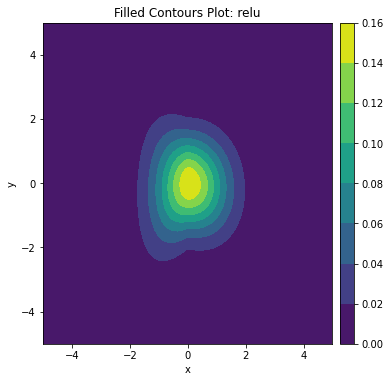

In [34]:
# Plot contour

activation='relu'
maf = tfd.TransformedDistribution(tfd.Sample(base_dist, sample_shape=[2]), make_masked_autoregressive_flow(activation=activation))

plot_contour_prob([maf], scale_fig=6, title=[activation])

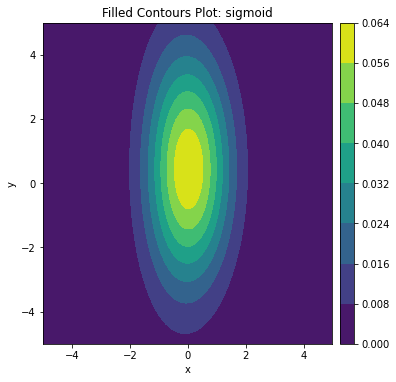

In [35]:
activation='sigmoid'
maf = tfd.TransformedDistribution(tfd.Sample(base_dist, sample_shape=[2]), make_masked_autoregressive_flow(activation=activation))

plot_contour_prob([maf], scale_fig=6, title=[activation])

### Samples from trainable Distribution

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [37]:
# Make samples

x = base_dist.sample((1000, 2))
names = [base_dist.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

In [39]:
# Define a scatter plot routine for the bijectors

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1
    plt.show()

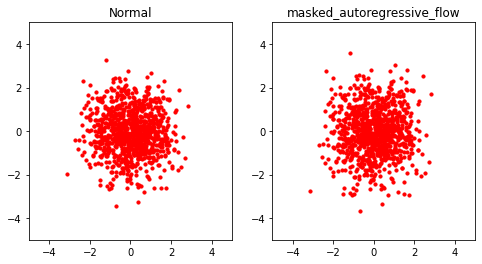

In [40]:
# Plot

_plot(samples)

### Training a MaskedAutoregressiveFlow bijector

In [41]:
from tensorflow.keras.callbacks import LambdaCallback

In [42]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [43]:
# Train the distribution

history = train_dist_routine(trainable_dist, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 2.8780, val_loss: 2.8994

 Epoch 51/600 
	 loss: 2.7732, val_loss: 2.7766

 Epoch 101/600 
	 loss: 2.6878, val_loss: 2.6586

 Epoch 151/600 
	 loss: 2.6395, val_loss: 2.6031

 Epoch 201/600 
	 loss: 2.5874, val_loss: 2.5471

 Epoch 251/600 
	 loss: 2.5108, val_loss: 2.4652

 Epoch 301/600 
	 loss: 2.4048, val_loss: 2.3522

 Epoch 351/600 
	 loss: 2.2999, val_loss: 2.2454

 Epoch 401/600 
	 loss: 2.2376, val_loss: 2.1815

 Epoch 451/600 
	 loss: 2.1992, val_loss: 2.1444

 Epoch 501/600 
	 loss: 2.1680, val_loss: 2.1162

 Epoch 551/600 
	 loss: 2.1407, val_loss: 2.0913


In [44]:
# Get losses

train_losses = history.history['loss']
val_losses = history.history['val_loss']

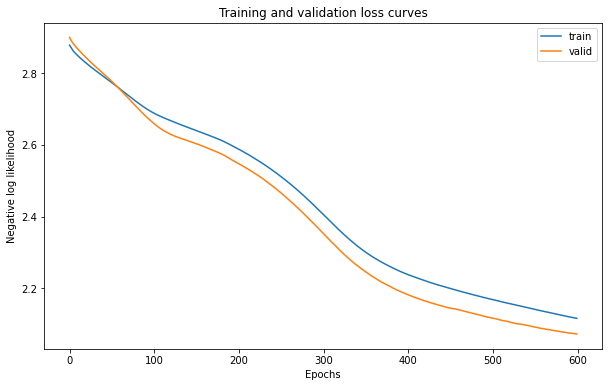

In [45]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='valid')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Negative log likelihood')
plt.title('Training and validation loss curves')
plt.show()

In [46]:
# Make samples

x = base_dist.sample((1000, 2))
names = [base_dist.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

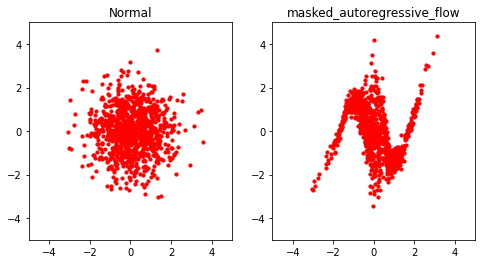

In [47]:
# Plot

_plot(samples)

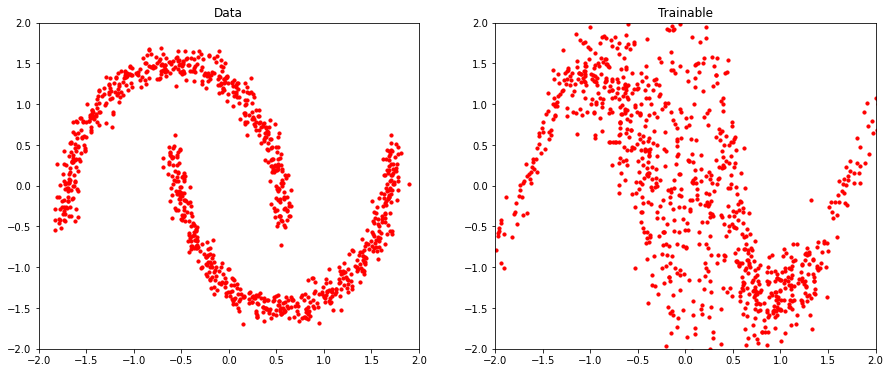

In [48]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

visualize_training_data(samples)

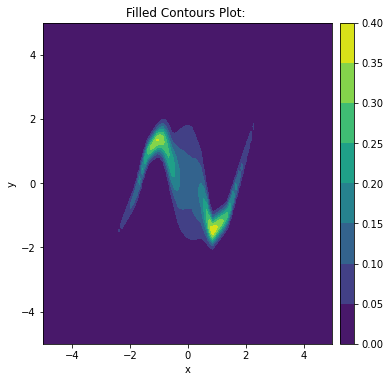

In [49]:
# Plot contour

plot_contour_prob([trainable_dist], scale_fig=6)

### Training a chain a MaskedAutoregressiveFlow bijectors

In [74]:
# Define a more expressive model

num_bijectors = 6
bijectors = []

for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(hidden_units=[256, 256], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1, 0]))
    
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [75]:
# Define the trainable distribution

trainable_dist = tfd.TransformedDistribution(distribution=tfd.Sample(base_dist, sample_shape=[2]), bijector=flow_bijector)
trainable_dist

<tfp.distributions.TransformedDistribution 'chain_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flowSampleNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [76]:
# Make samples

def make_samples():
    x = base_dist.sample((1000, 2))
    samples = [x]
    names = [base_dist.name]
    for bijector in reversed(trainable_dist.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

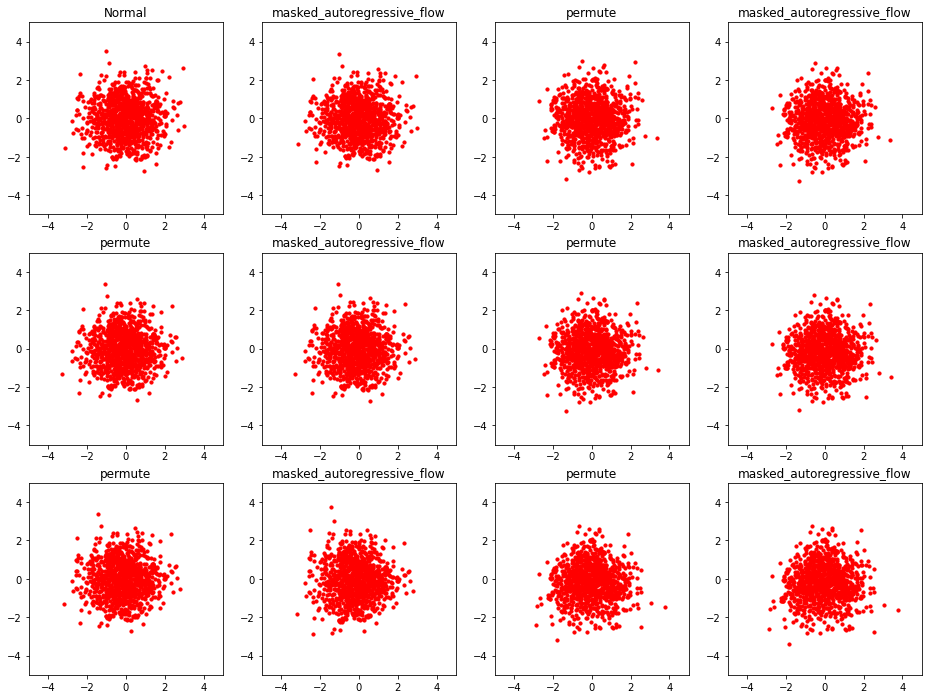

In [77]:
# Plot

_plot(samples, 3)

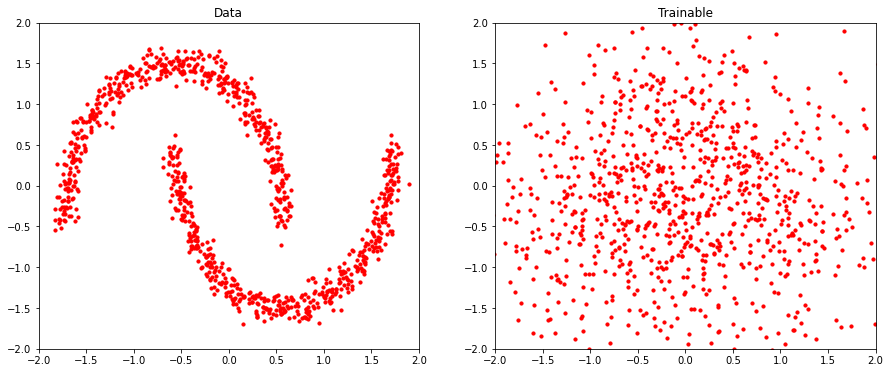

In [78]:
# Plot
visualize_training_data(samples)

In [79]:
# Train the distribution

history = train_dist_routine(trainable_dist, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 2.8592, val_loss: 2.6513

 Epoch 51/600 
	 loss: 2.2185, val_loss: 2.2064

 Epoch 101/600 
	 loss: 2.1345, val_loss: 2.1158

 Epoch 151/600 
	 loss: 1.7607, val_loss: 1.7171

 Epoch 201/600 
	 loss: 2.2620, val_loss: 2.2233

 Epoch 251/600 
	 loss: 2.1673, val_loss: 2.0896

 Epoch 301/600 
	 loss: 1.7445, val_loss: 1.8148

 Epoch 351/600 
	 loss: 1.6243, val_loss: 1.6601

 Epoch 401/600 
	 loss: 1.4955, val_loss: 1.5109

 Epoch 451/600 
	 loss: 1.4038, val_loss: 1.4498

 Epoch 501/600 
	 loss: 1.2916, val_loss: 1.3935

 Epoch 551/600 
	 loss: 1.2485, val_loss: 1.3925


In [80]:
# Get losses

train_losses = history.history['loss']
val_losses = history.history['val_loss']

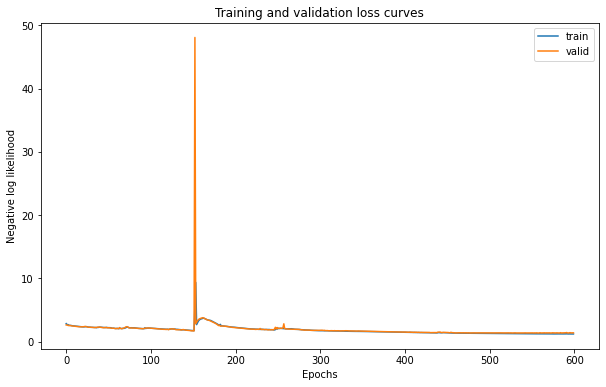

In [81]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='valid')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Negative log likelihood')
plt.title('Training and validation loss curves')
plt.show()

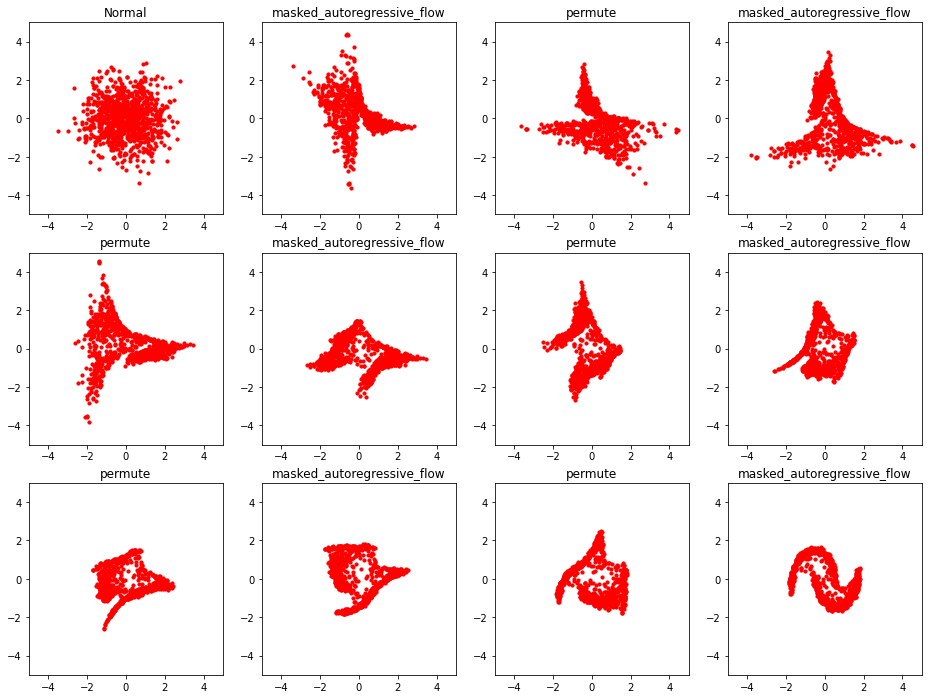

In [82]:
# Make samples and plot
names, samples = make_samples()
_plot(samples, 3)

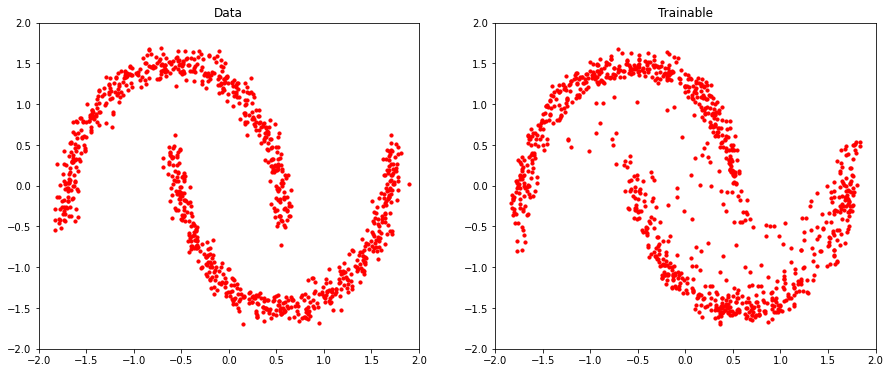

In [83]:
# Plot

visualize_training_data(samples)

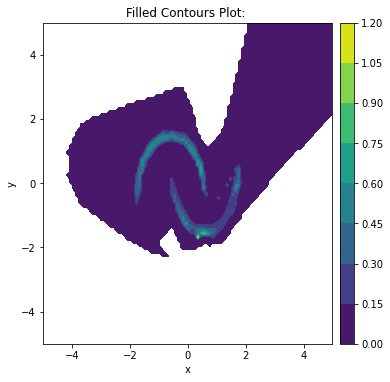

In [84]:
# Plot

plot_contour_prob([trainable_dist], scale_fig=6)